In [1]:
import os
from functools import partial

import gym
import torch
from gym.spaces.box import Box
from gym_minigrid.wrappers import *
from procgen import ProcgenEnv
from baselines.common.vec_env import VecEnvWrapper, VecExtractDictObs, VecMonitor, VecNormalize, SubprocVecEnv

from custom_envs import ObstructedMazeGamut
from level_replay.level_sampler import LevelSampler

In [18]:
import matplotlib.pyplot as plt

In [2]:
class SeededSubprocVecEnv(SubprocVecEnv):
    def __init__(self, env_fns):
        super(SubprocVecEnv, self).__init__(env_fns, )

    def seed_async(self, seed, index):
        self._assert_not_closed()
        self.remotes[index].send(('seed', seed))
        self.waiting = True

    def seed_wait(self, index):
        self._assert_not_closed()
        obs = self.remotes[index].recv()
        self.waiting = False
        return obs

    def seed(self, seed, index):
        self.seed_async(seed, index)
        return self.seed_wait(index)

    def observe_async(self, index):
        self._assert_not_closed()
        self.remotes[index].send(('observe', None))
        self.waiting = True

    def observe_wait(self, index):
        self._assert_not_closed()
        obs = self.remotes[index].recv()
        self.waiting = False
        return obs

    def observe(self, index):
        self.observe_async(index)
        return self.observe_wait(index)

    def level_seed_async(self, index):
        self._assert_not_closed()
        self.remotes[index].send(('level_seed', None))
        self.waiting = True

    def level_seed_wait(self, index):
        self._assert_not_closed()
        level_seed = self.remotes[index].recv()
        self.waiting = False
        return level_seed

    def level_seed(self, index):
        self.level_seed_async(index)
        return self.level_seed_wait(index)

class TransposeObs(gym.ObservationWrapper):
    def __init__(self, env=None):
        """
        Transpose observation space (base class)
        """
        super(TransposeObs, self).__init__(env)


class TransposeImageProcgen(TransposeObs):
    def __init__(self, env=None, op=[0, 3, 2, 1]):
        """
        Transpose observation space for images
        """
        super(TransposeImageProcgen, self).__init__(env)
        self.op = op
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0], [
                obs_shape[2], obs_shape[1], obs_shape[0]
            ],
            dtype=self.observation_space.dtype)

    def observation(self, ob):
        if ob.shape[0] == 1:
            ob = ob[0]
        return ob.transpose(self.op[0], self.op[1], self.op[2], self.op[3])


class VecPyTorchProcgen(VecEnvWrapper):
    def __init__(self, venv, device, level_sampler=None):
        """
        Environment wrapper that returns tensors (for obs and reward)
        """
        super(VecPyTorchProcgen, self).__init__(venv)
        self.device = device

        self.level_sampler = level_sampler

        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0], 
            [3, 64, 64],
            dtype=self.observation_space.dtype)

    @property
    def raw_venv(self):
        rvenv = self.venv
        while hasattr(rvenv, 'venv'):
            rvenv = rvenv.venv
        return rvenv

    def reset(self):
        if self.level_sampler:
            seeds = torch.zeros(self.venv.num_envs, dtype=torch.int)
            for e in range(self.venv.num_envs):
                seed = self.level_sampler.sample('sequential')
                seeds[e] = seed
                self.venv.seed(seed,e)

        obs = self.venv.reset()
        if obs.shape[1] != 3:
            obs = obs.transpose(0, 3, 1, 2)
        obs = torch.from_numpy(obs).float().to(self.device) / 255.

        if self.level_sampler:
            return obs, seeds
        else:
            return obs

    def step_async(self, actions):
        if isinstance(actions, torch.LongTensor) or len(actions.shape) > 1:
            # Squeeze the dimension for discrete actions
            actions = actions.squeeze(1)
        actions = actions.cpu().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        obs, reward, done, info = self.venv.step_wait()
        # print(f"stepping {info[0]['level_seed']}, done: {done}")

        # reset environment here
        if self.level_sampler:
            for e in done.nonzero()[0]:
                seed = self.level_sampler.sample()
                self.venv.seed(seed, e) # seed resets the corresponding level

            # NB: This reset call propagates upwards through all VecEnvWrappers
            obs = self.raw_venv.observe()['rgb'] # Note reset does not reset game instances, but only returns latest observations

        if obs.shape[1] != 3:
            obs = obs.transpose(0, 3, 1, 2)
        obs = torch.from_numpy(obs).float().to(self.device) / 255.
        reward = torch.from_numpy(reward).unsqueeze(dim=1).float()

        return obs, reward, done, info


class VecMinigrid(SeededSubprocVecEnv):
    def __init__(self, num_envs, env_name, seeds=None):
        if seeds is None:
            seeds = [int.from_bytes(os.urandom(4), byteorder="little") for _ in range(num_envs)]
        else:
            seeds = [int(s) for s in np.random.choice(seeds, num_envs)]

        env_fn = [partial(self._make_minigrid_env, env_name, seeds[i]) for i in range(num_envs)]

        super(SeededSubprocVecEnv, self).__init__(env_fn)

    @staticmethod
    def _make_minigrid_env(env_name, seed):
        env = gym.make(env_name)
        env.seed(seed)
        env = FullyObsWrapper(env)
        env = ImgObsWrapper(env)
        return env

class VecPyTorchMinigrid(VecEnvWrapper):
    def __init__(self, venv, device, level_sampler=None):
        """
        Environment wrapper that returns tensors (for obs and reward)
        """
        super(VecPyTorchMinigrid, self).__init__(venv)
        self.device = device
        self.is_first_step = False

        self.level_sampler = level_sampler

        m, n, c = venv.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0], 
            [c, m, n],
            dtype=self.observation_space.dtype)

    @property
    def raw_venv(self):
        rvenv = self.venv
        while hasattr(rvenv, 'venv'):
            rvenv = rvenv.venv
        return rvenv

    def reset(self):
        if self.level_sampler:
            seeds = torch.zeros(self.venv.num_envs, dtype=torch.int)
            for e in range(self.venv.num_envs):
                seed = self.level_sampler.sample('sequential')
                seeds[e] = seed
                self.venv.seed(seed,e)

        obs = self.venv.reset()
        if obs.shape[1] != 3:
            obs = obs.transpose(0, 3, 1, 2)
        obs = torch.from_numpy(obs).float().to(self.device)
        # obs = torch.from_numpy(obs).float().to(self.device) / 255.

        if self.level_sampler:
            return obs, seeds
        else:
            return obs

    def step_async(self, actions):
        if isinstance(actions, torch.LongTensor) or len(actions.shape) > 1:
            # Squeeze the dimension for discrete actions
            actions = actions.squeeze(1)
        actions = actions.cpu().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        obs, reward, done, info = self.venv.step_wait()

        # reset environment here
        for e in done.nonzero()[0]:
            if self.level_sampler:
                seed = self.level_sampler.sample()
            else:
                # seed = int.from_bytes(os.urandom(4), byteorder="little")
                seed = np.random.randint(1,1e12)
            obs[e] = self.venv.seed(seed, e) # seed resets the corresponding level

        if obs.shape[1] != 3:
            obs = obs.transpose(0, 3, 1, 2)
        obs = torch.from_numpy(obs).float().to(self.device)
        # obs = torch.from_numpy(obs).float().to(self.device) / 255.
        reward = torch.from_numpy(reward).unsqueeze(dim=1).float()

        return obs, reward, done, info


PROCGEN_ENVS = {
    "bigfish",
    "bossfight",
    "caveflyer",
    "chaser",
    "climber",
    "coinrun",
    "dodgeball",
    "fruitbot",
    "heist",
    "jumper",
    "leaper",
    "maze",
    "miner",
    "ninja",
    "plunder",
    "starpilot",
}

# Makes a vector environment
def make_lr_venv(num_envs, env_name, seeds, device, **kwargs):
    level_sampler = kwargs.get('level_sampler')
    level_sampler_args = kwargs.get('level_sampler_args')

    ret_normalization = not kwargs.get('no_ret_normalization', False)

    if env_name in PROCGEN_ENVS:
        num_levels = kwargs.get('num_levels', 1)
        start_level = kwargs.get('start_level', 0)
        distribution_mode = kwargs.get('distribution_mode', 'easy')
        paint_vel_info = kwargs.get('paint_vel_info', False)

        venv = ProcgenEnv(num_envs=num_envs, env_name=env_name, \
            num_levels=num_levels, start_level=start_level, \
            distribution_mode=distribution_mode,
            paint_vel_info=paint_vel_info)
        venv = VecExtractDictObs(venv, "rgb")
        venv = VecMonitor(venv=venv, filename=None, keep_buf=100)
        venv = VecNormalize(venv=venv, ob=False, ret=ret_normalization)

        if level_sampler_args:
            level_sampler = LevelSampler(
                seeds, 
                venv.observation_space, venv.action_space,
                **level_sampler_args)

        envs = VecPyTorchProcgen(venv, device, level_sampler=level_sampler)

    elif env_name.startswith('MiniGrid'):
        venv = VecMinigrid(num_envs=num_envs, env_name=env_name, seeds=seeds)
        venv = VecMonitor(venv=venv, filename=None, keep_buf=100)
        venv = VecNormalize(venv=venv, ob=False, ret=ret_normalization)

        if level_sampler_args:
            level_sampler = LevelSampler(
                seeds, 
                venv.observation_space, venv.action_space,
                **level_sampler_args)

        elif seeds:
            level_sampler = LevelSampler(
                seeds,
                venv.observation_space, venv.action_space,
                strategy='random',
            )

        envs = VecPyTorchMinigrid(venv, device, level_sampler=level_sampler)

    else:
        raise ValueError(f'Unsupported env {env_name}')

    return envs, level_sampler

In [4]:
envs, sampler = make_lr_venv(num_envs=1, env_name='bigfish', seeds=None, device="cpu")

In [23]:
envs.venv.action_space

Discrete(15)

In [15]:
obs = envs.venv.reset()

In [22]:
obs.shape

(1, 64, 64, 3)

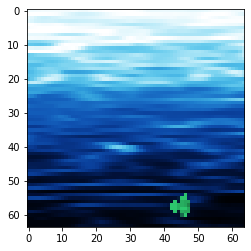

In [20]:
plt.imshow(obs.reshape(64, 64, 3))